# lasso-100-restricted

# Direct Regression

In [1]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso, Ridge, LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score
import pickle
import time
from reed import drop_missing_treatment_or_outcome, Model, transform_outcome

# set global notebook options
pd.options.display.max_columns = 200
pd.options.display.max_rows = 500
pd.options.display.max_colwidth = 100

%matplotlib inline

%load_ext autoreload
%autoreload 2

#### Parameters

In [2]:
optimisation_metric = 'neg_mean_squared_error'
evaluation_metrics = ('r2','neg_mean_squared_error')
log_outcome=True
standardize_outcome=True
load_from_cache=False
exclude_patterns = [
    '^reduhl$', '^rehllt$', '^redudl$', '^redufl$', '^redllt$', '^refllt$',
    '^rlwage$', '^mh$', '^mhbm$', '^wkhr$', '^y_', '^p_rcom','^p_rdf','^p_cotrl',
    '^xwaveid$','p_rcom18','^aedcq', '^abnfsty','^aedcqfpt','^aedqstdy'
]
data_load_func = lambda filepath: pd.read_csv(filepath, index_col='xwaveid')

configuration_name = 'default'
outcome = 'y_wsce'#'y_wsce'
treatment = 'redufl'
test=False
data_file = "data/all_lasso_selected_100_restricted.csv"
release = "restricted" # only used to determine which metadata file to read. 

In [3]:
# Parameters
configuration_name = "lasso-100-restricted"
outcome = "y_wsce"
treatment = "redufl"
test = False
data_file = "data/all_lasso_selected_100_restricted.csv"
release = "restricted"


In [4]:
# parameters that depend on those set above (which may have been inserted by Papermill)
if test:
    inner_cv = 2
    outer_cv = 2
    bootstrap_samples = 3

else:
    inner_cv = 5
    outer_cv = 10
    bootstrap_samples = 50

cross_val_cache = f"data/cross-val-{configuration_name}.pkl"#"data/cross-val-all.pkl"
bootstrap_cache = f"data/bootstrap-{configuration_name}.pkl"#"data/bootstrap-all.pkl"

### Load Data 
   - drop rows missing the specified treatment or outcome

Dropped 284 rows missing treatment or outcome.


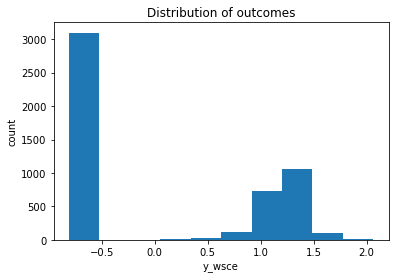

In [5]:
data = data_load_func(data_file)
drop_missing_treatment_or_outcome(data, treatment, outcome)
data[outcome] = transform_outcome(data[outcome],log_outcome, standardize_outcome)

    
plt.hist(data[outcome])
plt.xlabel(outcome)
plt.ylabel("count")
plt.title("Distribution of outcomes");

### Set up models
Specify which models to use and the hyper-parameter space to search over for each

In [6]:
from sklearn.linear_model import Lasso, Ridge
from sklearn.ensemble import GradientBoostingRegressor
from direct_regression import importance_from_coef

def construct_models():
    models = [
        Model('ridge',Ridge(), 
              parameters = {
                  'alpha':np.logspace(-1,4,30)
              },
              importance_func=importance_from_coef
        ),
        Model('lasso',Lasso(),
              parameters = {
                  'alpha':np.logspace(-2,4,30)
              },
              importance_func=importance_from_coef
        ), 
        Model('gbr',GradientBoostingRegressor(n_iter_no_change=20, max_depth=2),
              parameters = {
                'max_features':np.linspace(0,1,6)[1:],
                'learning_rate':np.logspace(-3,0,10),
                'min_samples_leaf':np.logspace(0,3,10).astype(int)
              }
        ),
    ]
    return models

# used for quick tests
def construct_test_models(): 
    models = [
        Model('Ridge',Ridge(),
              parameters = {'alpha':np.logspace(1,4,2)},
              importance_func=importance_from_coef
        ),
        Model('gbr',GradientBoostingRegressor(n_iter_no_change=20, max_depth=2),
              parameters = {
                'max_features':np.linspace(0,1,4)[1:],
              }
        ),
    ]
    return models

model_init = construct_test_models if test else construct_models

### Prepare data for modeling
   - split into treated/control
   - impute missing values and scale
   - separate features from outcomes&treatments

In [7]:
from direct_regression import seperate_and_transform_data
X0, X1, y0, y1, X, y, t, features = seperate_and_transform_data(data, treatment, outcome)
print("Control data dimensions: ",X0.shape)
print("Treated data dimensions:",X1.shape)

Control data dimensions:  (3789, 91)
Treated data dimensions: (1368, 91)


### Compute unconditional/unadjusted estimate of treatment effect

In [8]:
from direct_regression import print_unconditional_effects
print_unconditional_effects(data, treatment, y0, y1)

Proportion Treated:27%
Average outcome under Control:-0.14±0.02
Average outcome under Treatment:0.37±0.03
Unadjusted treatment estimate 0.51


### Propensity model

- Run primarily to check for violations over overlap assumptions.

In [9]:
from reed import visualise_propensity_model_performance
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

X_train, X_test, t_train, t_test = train_test_split(X,t,stratify=t)
pmodel = LogisticRegressionCV(Cs = np.logspace(-5,-1,20), penalty='l2', max_iter=10000)
pmodel.fit(X_train, t_train);

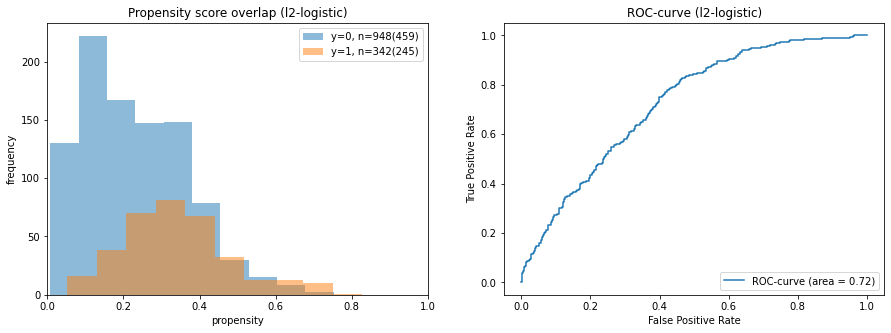

In [10]:
visualise_propensity_model_performance(t_test, pmodel.predict_proba(X_test)[:,1],'l2-logistic',bins=10)

In [11]:
def propensity_coefficients(model, features):
    if hasattr(model,'best_estimator_'):
        model = model.best_estimator_
    coef = model.coef_[0]
    
    with open(f'data/metadata_{release}.pkl','rb') as f:
        meta = pickle.load(f)
        labels = [meta.column_names_to_labels.get(f) for f in features]
    return pd.DataFrame({'label': labels, "c":coef,'abs':np.abs(coef)},index=features).sort_values(by='abs',ascending=False).head(50)
print("Propensity Model Coefficients")      
propensity_coefficients(pmodel, features).head(20)

Propensity Model Coefficients


,label,c,abs
atcyng,DV: Age youngest own child (excl. resident foster/step),-0.160873,0.160873
ahsyrcad,DV: Years at current address,-0.147275,0.147275
ahhyng,DV: Age of youngest person in household,-0.143525,0.143525
ajbempt,DV: Tenure with current employer (years),-0.118980,0.118980
aehtjbyr,D3a1 Years in paid work,-0.118850,0.118850
ahgrf,HF10 Follow-up stage individual interview outcome,0.118155,0.118155
atcnr,DV: Number of own non-resident children,-0.112971,0.112971
amhn10yr,K12 How many homes lived in during last 10 years,0.110223,0.110223
ajsl4wk,F1 Looked for work in last 4 weeks,0.098117,0.098117
ahiwscei,DV: Household current weekly gross wages & salary - all jobs ($) [imputed],0.093798,0.093798


In [12]:
from direct_regression import nested_cross_val

models0, models1, results = nested_cross_val(
    model_init,
    cross_val_cache,
    X0, X1, y0, y1,
    optimisation_metric,
    evaluation_metrics,
    innercv=inner_cv,
    outercv=outer_cv,
    load_from_cache=load_from_cache
)

Fitting ridge ...Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Done
Fitting lasso ...Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Done
Fitting gbr ...Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Done
Caching results to data/cross-val-lasso-100-restricted.pkl


### Report estimate ATE and model performance

  - Mean and Std of prediction performance for each model (both treatment & control surface)
  - Mean and Std of average treatment effect for each model

,ACE,ACE_std,control_r2,control_r2_std,treated_r2,treated_r2_std,control_neg_mean_squared_error,control_neg_mean_squared_error_std,treated_neg_mean_squared_error,treated_neg_mean_squared_error_std
ridge,0.18,0.01,0.42,0.03,0.20,0.05,-0.54,0.04,-0.81,0.05
lasso,0.21,0.02,0.42,0.05,0.21,0.07,-0.53,0.06,-0.80,0.08
gbr,0.15,0.02,0.45,0.05,0.23,0.05,-0.51,0.04,-0.78,0.06


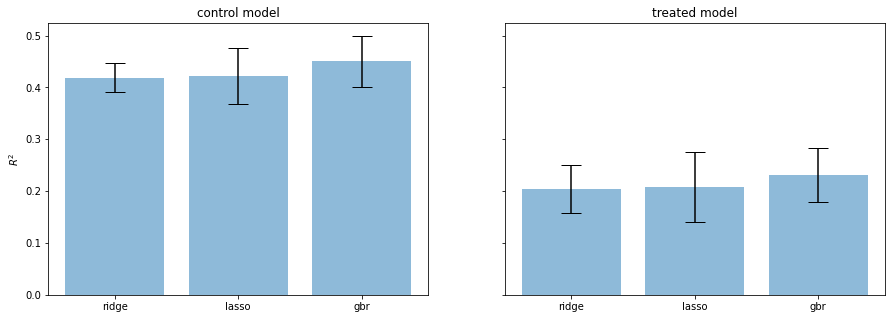

In [13]:
from direct_regression import visualise_ate
metrics, ate_vals = visualise_ate(results,X,evaluation_metrics);

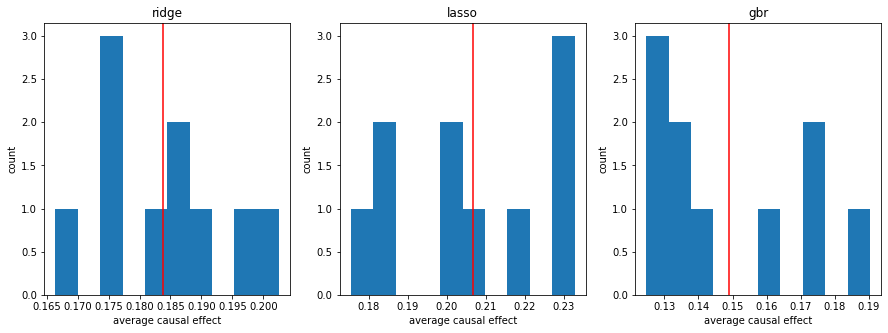

In [14]:
from direct_regression import plot_ate_distribution
plot_ate_distribution(ate_vals)

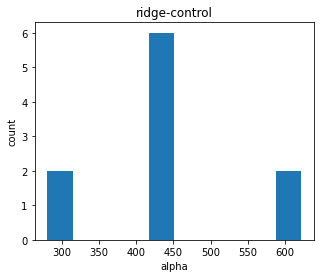

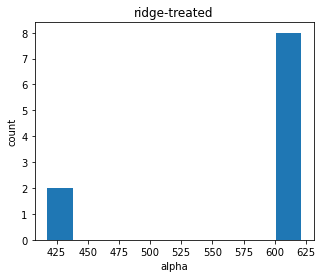

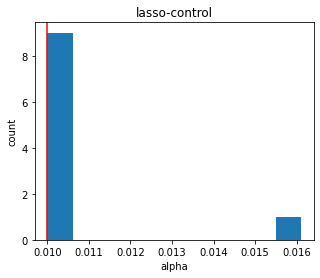

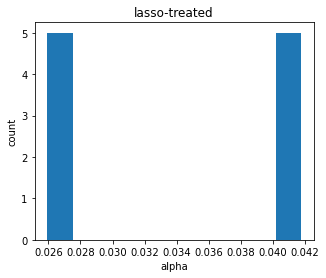

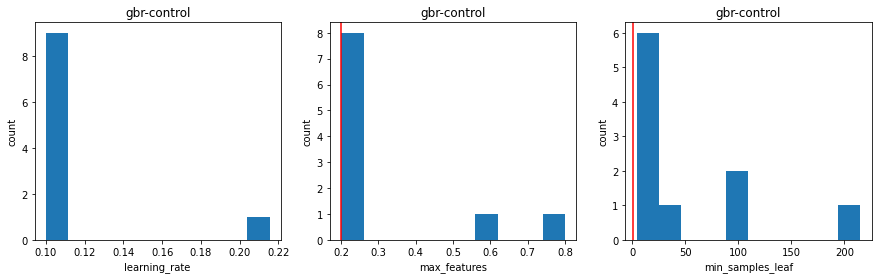

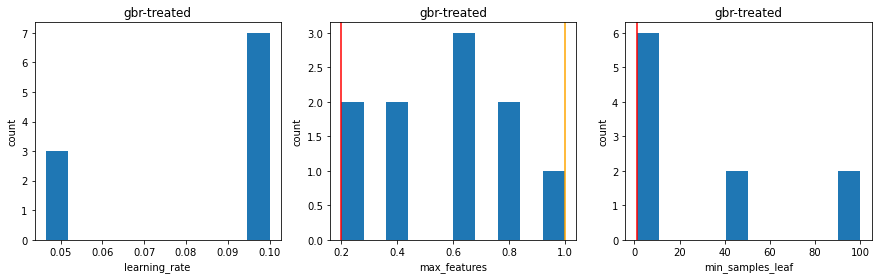

In [15]:
from direct_regression import plot_hyperparam_distributions
for model, (results0, results1) in results.items():
    plot_hyperparam_distributions(results0,f"{model}-control")
    plot_hyperparam_distributions(results1,f"{model}-treated")

### Visualise models
- Features responsible for treatment effect heterogeneity & functional form (with uncertainty)
      - coefficeints for linear models
      - TODO permutation importance & partial dependence curves for non-linear models

In [16]:
from direct_regression import display_feature_importance
display_feature_importance(models0, models1, results, features);

ridge


,importance_mean,importance_std,Δcoef_mean,Δcoef_std,coef_treat_mean,coef_treat_std,coef_cntr_mean,coef_cntr_std
feature,,,,,,,,
artage1,0.191180,0.005926,0.098921,0.016178,-0.141719,0.006270,-0.240640,0.012720
atcyng,0.089987,0.003747,-0.002929,0.008913,-0.091452,0.005704,-0.088523,0.005939
atcnr,0.074579,0.004413,-0.039740,0.004889,-0.094449,0.005841,-0.054709,0.004096
awscme,0.069737,0.008006,-0.114622,0.010091,0.012426,0.006034,0.127048,0.011946
ahifapti,0.065172,0.001829,0.000158,0.012828,-0.065093,0.006313,-0.065251,0.007008
ahhyng,0.064107,0.002709,0.003436,0.006618,-0.062389,0.004284,-0.065825,0.004269
aehtjbyr,0.063822,0.002399,-0.029371,0.003780,-0.078507,0.003985,-0.049136,0.001667
ahsyrcad,0.054475,0.003424,0.008770,0.008993,-0.050090,0.005882,-0.058860,0.005412
atifditp,0.054003,0.005602,-0.002937,0.012469,0.052535,0.010525,0.055472,0.005453


lasso


,importance_mean,importance_std,Δcoef_mean,Δcoef_std,coef_treat_mean,coef_treat_std,coef_cntr_mean,coef_cntr_std
feature,,,,,,,,
artage1,0.258755,0.008383,0.062715,0.018217,-0.227397,0.015846,-0.290113,0.007442
atcyng,0.140305,0.009589,-0.049293,0.019263,-0.164952,0.016021,-0.115658,0.010619
atcnr,0.089639,0.009158,-0.083996,0.015633,-0.131637,0.016697,-0.047641,0.003338
awscme,0.075639,0.007761,-0.148625,0.015533,0.001327,0.004197,0.149952,0.014950
ahifapti,0.063039,0.006170,-0.007327,0.011548,-0.066703,0.010969,-0.059376,0.004744
agh3a,0.042329,0.008550,0.010698,0.010921,0.047678,0.013165,0.036980,0.005702
aloimpew,0.041047,0.007808,-0.056636,0.014749,0.012729,0.013909,0.069365,0.006101
atifditp,0.039254,0.008314,-0.007712,0.022008,0.035398,0.015008,0.043109,0.012456
aehtjbyr,0.037061,0.013406,-0.023982,0.029692,-0.049052,0.028042,-0.025070,0.003721


### Compare against OLS on basic variables

In [17]:
basic = pd.read_csv("data/basic_variables.csv",index_col='xwaveid')
drop_missing_treatment_or_outcome(basic, treatment, outcome)
basic[outcome] = transform_outcome(basic[outcome],log_outcome, standardize_outcome)

    
X0b, X1b, y0b, y1b, Xb, yb, tb, featuresb = seperate_and_transform_data(basic, treatment, outcome)

def construct_basic_model():
    models = [
        Model('OLS',LinearRegression(),importance_func=importance_from_coef)
    ]
    return models

modelsb0, modelsb1, resultsb = nested_cross_val(
    construct_basic_model,
    "data/tmp.pkl",
    X0b, X1b, y0b, y1b,
    optimisation_metric,
    evaluation_metrics,
    innercv=inner_cv,
    outercv=outer_cv,
    load_from_cache=False)

Dropped 284 rows missing treatment or outcome.
Fitting OLS ...Done
Caching results to data/tmp.pkl


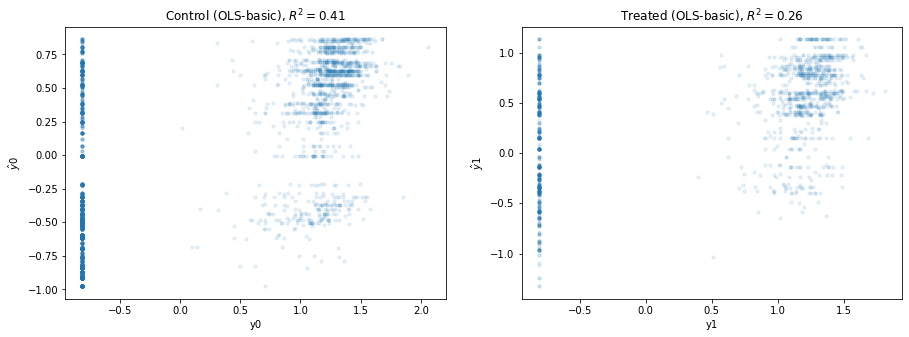

In [18]:
from sklearn.metrics import r2_score
y0b = resultsb['OLS'][0]['estimator'][0].predict(X0b)
y1b = resultsb['OLS'][1]['estimator'][0].predict(X1b)
fig, ax = plt.subplots(1,2, figsize=(15,5))
ax[0].scatter(y0, y0b,s=10,alpha=0.1)
ax[0].set_xlabel('y0')
ax[0].set_ylabel('$\\hat{y}0$');
ax[0].set_title(f'Control (OLS-basic), $R^2={r2_score(y0,y0b):.2f}$')

ax[1].scatter(y1, y1b,s=10,alpha=0.1)
ax[1].set_xlabel('y1')
ax[1].set_ylabel('$\\hat{y}1$');
ax[1].set_title(f'Treated (OLS-basic), $R^2={r2_score(y1,y1b):.2f}$');


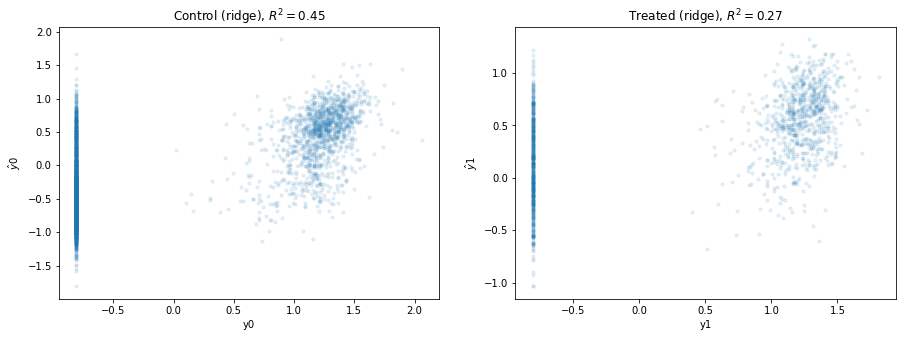

In [19]:
if 'ridge' in results.keys():
    y0a = results['ridge'][0]['estimator'][4].predict(X0)
    y1a = results['ridge'][1]['estimator'][4].predict(X1)
    fig, ax = plt.subplots(1,2, figsize=(15,5))
    ax[0].scatter(y0, y0a,s=10,alpha=0.1)
    ax[0].set_xlabel('y0')
    ax[0].set_ylabel('$\\hat{y}0$');
    ax[0].set_title(f'Control (ridge), $R^2={r2_score(y0,y0a):.2f}$')

    ax[1].scatter(y1, y1a,s=10,alpha=0.1)
    ax[1].set_xlabel('y1')
    ax[1].set_ylabel('$\\hat{y}1$');
    ax[1].set_title(f'Treated (ridge), $R^2={r2_score(y1,y1a):.2f}$');

# think about why these r2 scores are higher than on the holdout set (and whether they are likely overfitting)
# despite there being so few variables

In [20]:
from direct_regression import bootstrapped_cross_val
def extract_params(estimator):
    return estimator.coef_


bootstrap_results = bootstrapped_cross_val(
    model_init,
    bootstrap_cache,
    X0, X1, y0, y1,
    optimisation_metric,
    extract_params,
    inner_cv=inner_cv,
    load_from_cache=load_from_cache,
    samples=bootstrap_samples
)

Fitting ridge ...Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Done
Fitting lasso ...Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Done
Fitting gbr ...Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Done
Total time:12314.898377418518 seconds
Caching results to: data/bootstrap-lasso-100-restricted.pkl


####  Average treatment effects

In [21]:
from direct_regression import compute_ate
metrics, tau_estimatesb = compute_ate(bootstrap_results,X)
metrics

,ACE,ACE_std
ridge,0.210055,0.030085
lasso,0.212049,0.032259
gbr,0.159278,0.033401


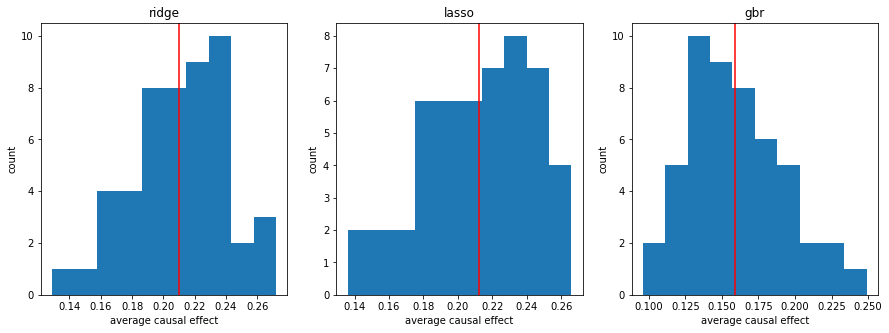

In [22]:
plot_ate_distribution(tau_estimatesb)

#### Distribution of hyper-parameters

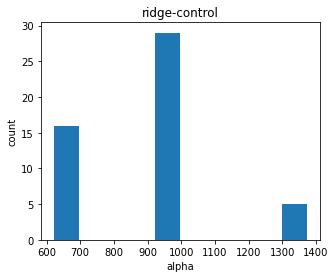

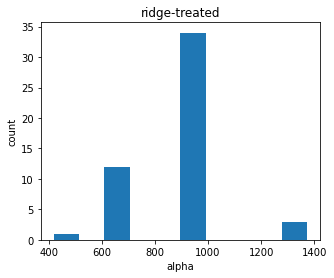

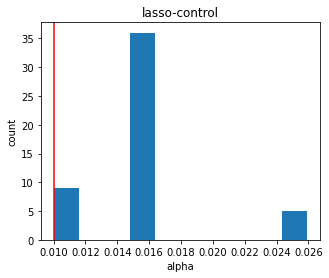

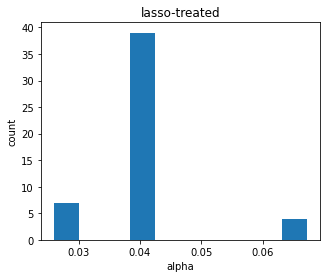

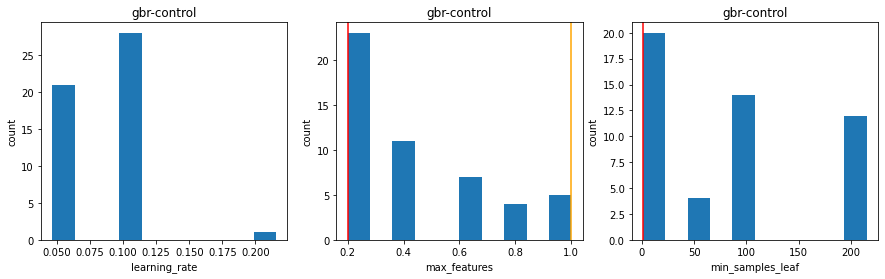

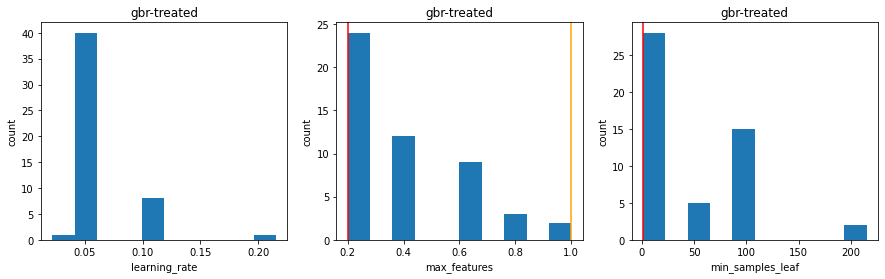

In [23]:
from direct_regression import plot_hyperparam_distributions
for model, (results0, results1) in bootstrap_results.items():
    plot_hyperparam_distributions(results0,f"{model}-control")
    plot_hyperparam_distributions(results1,f"{model}-treated")